## Прогнозирование временных рядов.

------

**Выбранный ряд:** Популярность Кинематографиеской вселенной Marvel в Google за период с января 2004 по декабрь 2017.

[Исходные данные](https://trends.google.ru/trends/explore?date=all&q=%2Fm%2F0by1sn_)  для ряда. Могут быть скачены в .csv файле путем нажатия соответствующей кнопки над графиком.

Скаченный файл рекомендуется переименовать в *marvel_universe-2004.csv* и положить в папку *data* в директории с данной тетрадкой.

----

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
plt.style.use('fivethirtyeight')

In [2]:
marvel = pd.read_csv('data/marvel_universe-2004.csv', skiprows=1, index_col=['Месяц'], parse_dates=['Месяц'])
marvel.rename(columns={'Кинематографическая вселенная Marvel: (По всему миру)': 'num_req'}, inplace=True)
marvel.index.rename('Month', inplace=True)
marvel.head()

,num_req
Month,
2004-01-01,14
2004-02-01,13
2004-03-01,12
2004-04-01,9
2004-05-01,12


In [4]:
marvel.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)

Text(0,0.5,'Popularity')

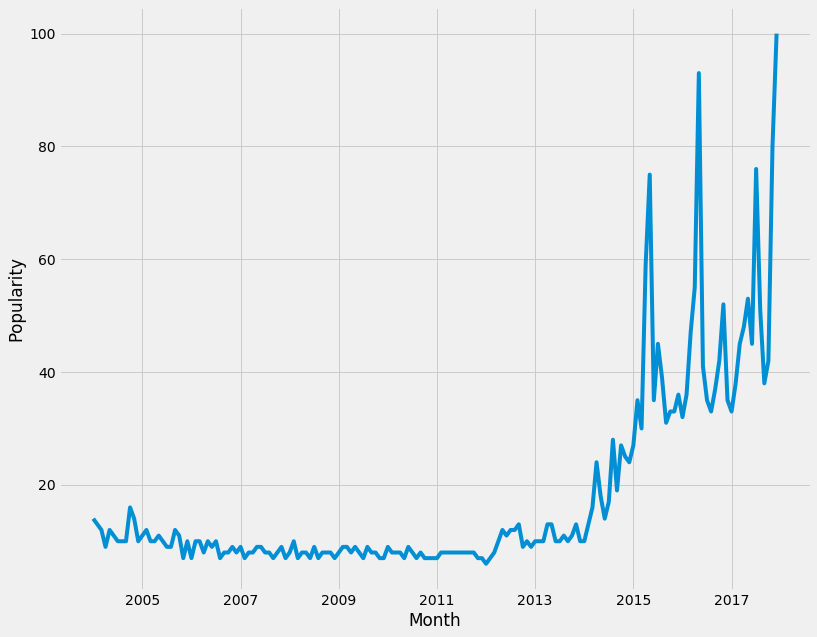

In [4]:
marvel['num_req'].plot()
plt.ylabel('Popularity')

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.998461


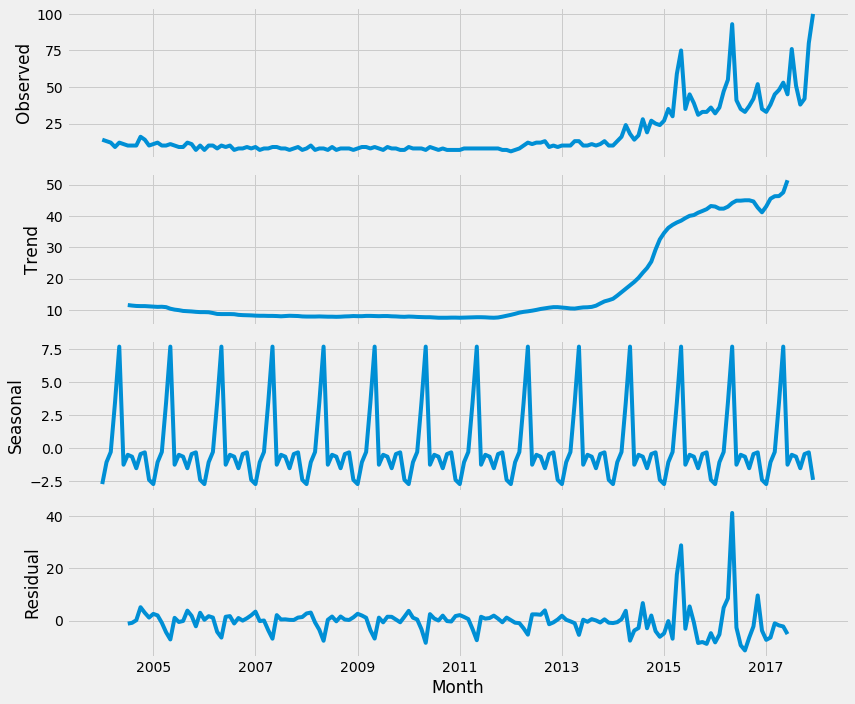

In [5]:
sm.tsa.seasonal_decompose(marvel['num_req']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(marvel['num_req'])[1])

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.214880


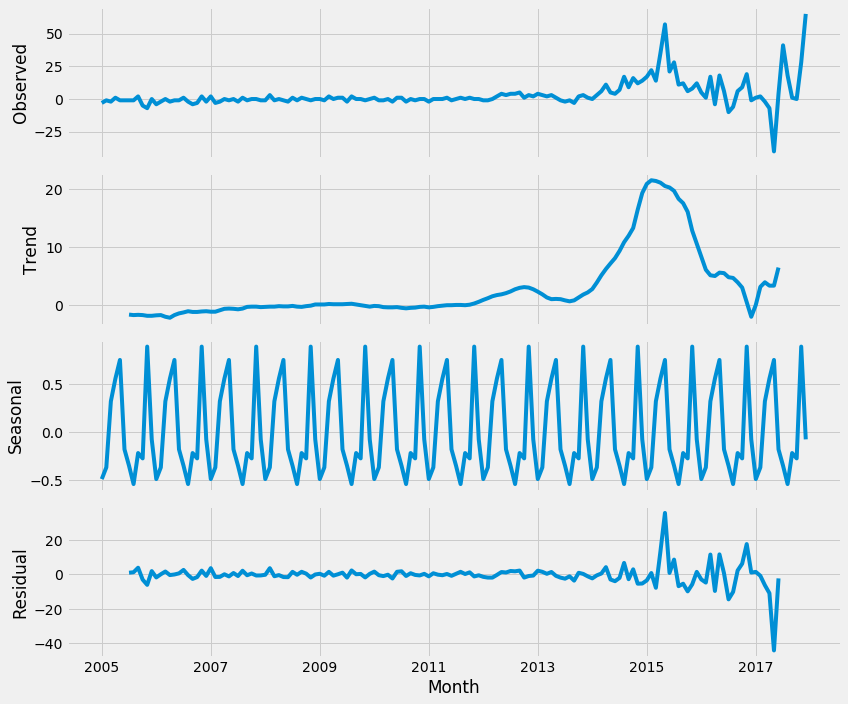

In [6]:
marvel['num_req_diff'] = marvel['num_req'] - marvel['num_req'].shift(12)
sm.tsa.seasonal_decompose(marvel['num_req_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(marvel['num_req_diff'][12:])[1])

Критерий Дики-Фуллера: p=0.012659


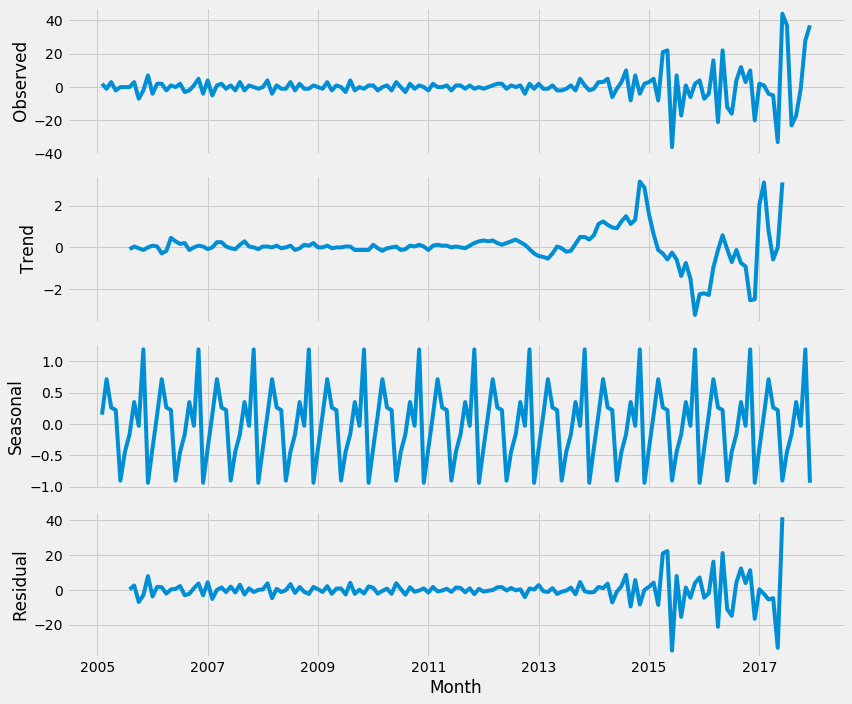

In [7]:
marvel['num_req_diff2'] = marvel['num_req_diff'] - marvel['num_req_diff'].shift(1)
sm.tsa.seasonal_decompose(marvel['num_req_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(marvel['num_req_diff2'][13:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось.

#### Подбор модели
Посмотрим на ACF и PACF полученного ряда:

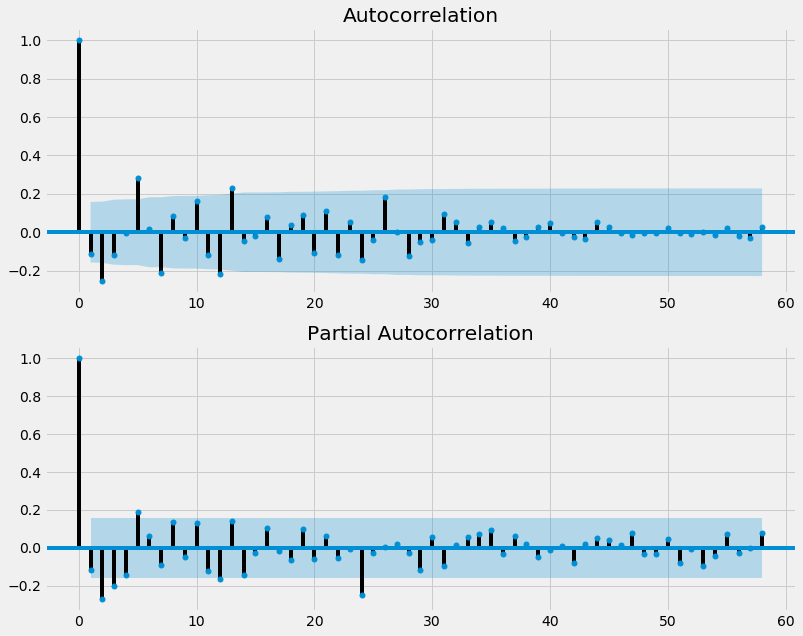

In [8]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(marvel['num_req_diff2'][13:].values.squeeze(), lags=58, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(marvel['num_req_diff2'][13:].values.squeeze(), lags=58, ax=ax);

Начальные приближения:

In [12]:
ps = range(0, 5)
d=1
qs = range(0, 1)
Ps = range(0, 5)
D=1
Qs = range(0, 5)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

125

In [14]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(marvel['num_req'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2min 11s, sys: 2.47 s, total: 2min 14s
Wall time: 1min 10s


In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
52  (4, 0, 2, 0)  1074.850526
53  (4, 0, 2, 1)  1076.844889
54  (4, 0, 3, 0)  1076.846874
55  (4, 0, 3, 1)  1078.045967
49  (4, 0, 0, 2)  1078.208511


In [16]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            num_req   No. Observations:                  168
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -530.425
Date:                            Fri, 15 Dec 2017   AIC                           1074.851
Time:                                    00:14:59   BIC                           1096.718
Sample:                                01-01-2004   HQIC                          1083.726
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4203      0.046     -9.153      0.000      -0.510      -0.330
ar.L2         -0.5685      0.055   

Критерий Стьюдента: p=0.214390
Критерий Дики-Фуллера: p=0.000000


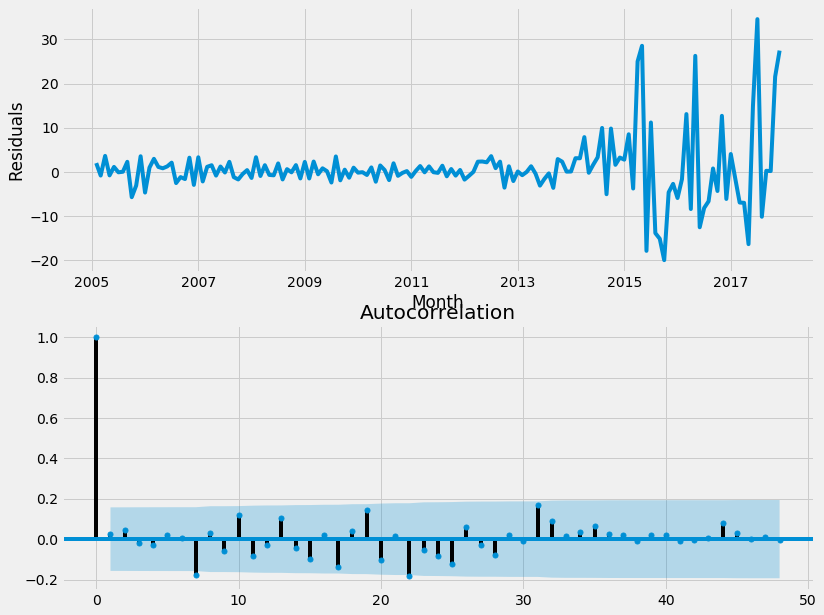

In [17]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

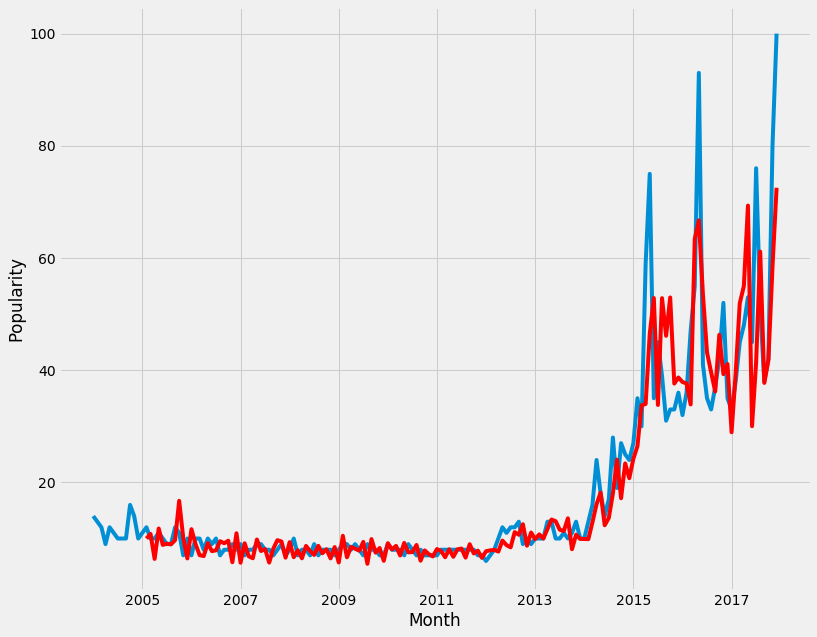

In [18]:
marvel['model'] = best_model.fittedvalues
marvel['num_req'].plot()
marvel['model'][13:].plot(color='r')
plt.ylabel('Popularity');

### Прогноз

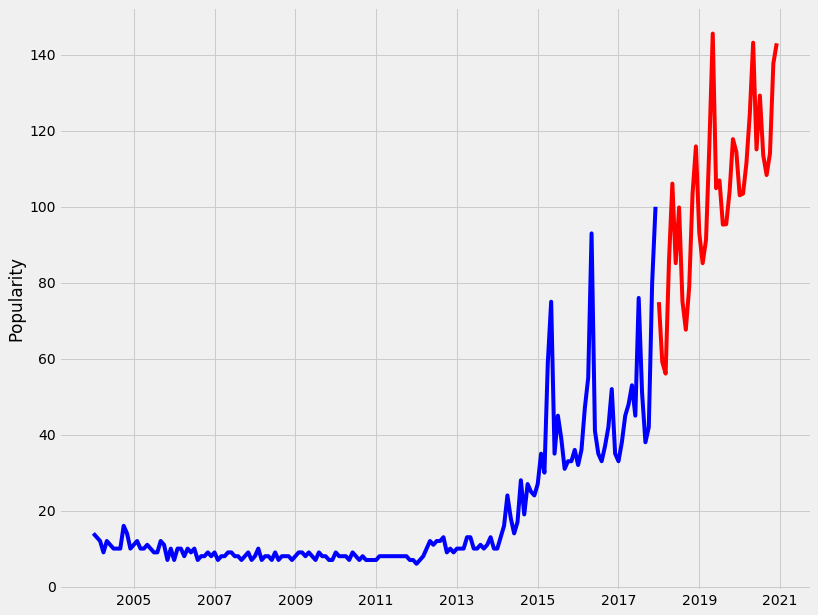

In [19]:
from dateutil.relativedelta import relativedelta
marvel2 = marvel[['num_req']]
date_list = [pd.datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=marvel2.columns)
marvel2 = pd.concat([marvel2, future])
marvel2['forecast'] = best_model.predict(start=168, end=210)

marvel2['num_req'].plot(color='b')
marvel2['forecast'].plot(color='r')
plt.ylabel('Popularity');

-------

### Заключение
В 2012 году вышел первый фильм "Мстители", благодаря чему популярность вселенной начала увеличиваться. Со временем выходило все больше и больше блокбастеров в рамках данной вселенной, из-за чего аудитория продолжала разрастаться. С ростом аудитории выросла и популярность данной вселенной в запросах в Google. По прогнозам ожидается, что она будет только расти, что вполне отвечает здравому смыслу, учитывая, сколько масштабных фильмов у них в планах.